# CyCle GAN TF 2.0

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.1.0'

## 1. 创建图片输入管道

In [6]:
# 展示数据集文件夹下的文件
os.listdir('./apple2orange')

['testA', 'testB', 'trainA', 'trainB']

In [11]:
# 获取苹果图片的路径地址
apple_images_train_path = glob.glob('./apple2orange/trainA/*.jpg')
apple_images_train_path[:3]

['./apple2orange/trainA\\n07740461_10012.jpg',
 './apple2orange/trainA\\n07740461_10019.jpg',
 './apple2orange/trainA\\n07740461_10037.jpg']

In [12]:
# 获取橘子图片的路径地址
orange_images_train_path = glob.glob('./apple2orange/trainB/*.jpg')
orange_images_train_path[:3]

['./apple2orange/trainB\\n07749192_1004.jpg',
 './apple2orange/trainB\\n07749192_1008.jpg',
 './apple2orange/trainB\\n07749192_1009.jpg']

In [15]:
# 获取测试集的图片路径
apple_images_test_path = glob.glob('./apple2orange/testA/*.jpg')
orange_images_test_path = glob.glob('./apple2orange/testB/*.jpg')
len(apple_images_test_path), len(orange_images_test_path)

(266, 248)

In [16]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [17]:
def load_image(path):
    img = read_jpg(path)
    img = tf.image.resize(img, (256, 256))
    img = img/127.5 - 1
    return img

In [18]:
# 创建dataset
dataset_train_apple = tf.data.Dataset.from_tensor_slices(apple_images_train_path)
dataset_train_orange = tf.data.Dataset.from_tensor_slices(orange_images_train_path)

dataset_test_apple = tf.data.Dataset.from_tensor_slices(apple_images_test_path)
dataset_test_orange = tf.data.Dataset.from_tensor_slices(orange_images_test_path)

In [19]:
# map()代表对象应用某个方法, 
# num_parallel_calls=AUTOTUNE代表根据你的机器实际配置，来自动创建合适的线程数进行数据读取
# cache()该方法括号中不写任何东西的话，代表自动将数据缓存到内存中，加快读取读取
dataset_train_apple = dataset_train_apple.map(load_image, 
                      num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size=200).batch(1)
dataset_train_orange = dataset_train_orange.map(load_image, 
                       num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size=200).batch(1)
dataset_test_apple = dataset_test_apple.map(load_image, 
                     num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size=200).batch(1)
dataset_test_orange = dataset_test_orange.map(load_image, 
                      num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size=200).batch(1)

In [20]:
dataset_train = tf.data.Dataset.zip((dataset_train_apple, dataset_train_orange))
dataset_test = tf.data.Dataset.zip((dataset_test_apple, dataset_test_orange))

In [21]:
dataset_train

<ZipDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

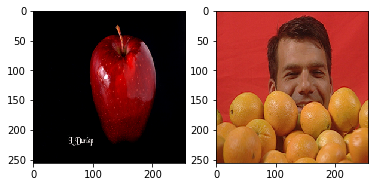

In [22]:
for apple, orange in dataset_train.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(apple[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(orange[0]))

## 2. 实例标准化(Instance Normalization)
>Instance Normalization作用于单张图片，而Batch Normalization作用于一个batch的图片，实例标准化非常适合用于style transfer任务中

In [23]:
!pip install -i https://pypi.douban.com/simple tensorflow_addons

Looking in indexes: https://pypi.douban.com/simple


In [26]:
import tensorflow_addons as tfa

## 3. 创建生成器

In [27]:
def downsample(filters, kernel_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=2, padding='same'),
        tfa.layers.InstanceNormalization(),
        tf.keras.layers.LeakyReLU()])
    return model

In [30]:
def upsample(filters, kernel_size, rate=0):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, 
                                        strides=2, padding='same'),
        tfa.layers.InstanceNormalization(),
        tf.keras.layers.Dropout(rate=rate),
        tf.keras.layers.LeakyReLU()])
    return model

In [33]:
def Generator():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    down_stack = [
        downsample(filters=64, kernel_size=4), # [128, 128, 64]
        downsample(filters=128, kernel_size=4), # [64, 64, 128]
        downsample(filters=256, kernel_size=4), # [32, 32, 256]
        downsample(filters=512, kernel_size=4), # [16, 16, 512]
        downsample(filters=512, kernel_size=4), # [8, 8, 512]
        downsample(filters=512, kernel_size=4), # [4, 4, 512]
        downsample(filters=512, kernel_size=4), # [2, 2, 512]
        downsample(filters=512, kernel_size=4)] # [1, 1, 512]
    
    up_stack = [
        upsample(filters=512, kernel_size=4, rate=0.5), # [2, 2, 512]
        upsample(filters=512, kernel_size=4, rate=0.5), 
        upsample(filters=512, kernel_size=4, rate=0.5), 
        upsample(filters=512, kernel_size=4),
        upsample(filters=256, kernel_size=4),
        upsample(filters=128, kernel_size=4),
        upsample(filters=64, kernel_size=4)]
    
    last = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2, 
                                           padding='same', activation='tanh')
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [34]:
gen = Generator()

In [37]:
def Discriminator():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    
    down1 = downsample(filters=64, kernel_size=4)(inputs)
    down2 = downsample(filters=128, kernel_size=4)(down1)
    down3 = downsample(filters=256, kernel_size=4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(filters=512, kernel_size=4, strides=1)(zero_pad1)
    norm = tfa.layers.InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(filters=1, kernel_size=4, strides=1)(zero_pad2)
    return tf.keras.Model(inputs=inputs, outputs=last)

In [38]:
dis = Discriminator()

## 4. 损失函数